In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Dense
#from keras.layers import LSTR
from keras.models import Sequential
from keras.models import load_model
#import tensorflow as tf
import matplotlib.pyplot as plt
#from sklearn.linear_model import SGDRegressor as SGD
from sklearn.preprocessing import MinMaxScaler
import joblib
#from tqdm import tqdm

Using TensorFlow backend.


In [2]:
# HyperParameters and Model Architecture
N_LAYERS = 5 #50 #25
N_NODES = 100 #50
TEST_SIZE = 0.20 #0.25
DAYS_TO_CLIP = 50 #35
EPOCHS = 4 #8

#tf.random.set_seed(21)

In [3]:
# specify location of time series data
file_path = '../data/interim/time_series.csv'

def read_data(file):
    """
    Read csv data from the specified file location.
    """
    df = pd.read_csv(file, index_col='Date')
    return df


# read time series data
time_series_df = read_data(file_path)

# test_df will be used to test on recent market performance
test_df = read_data(file_path) 


def clip_recent_days(df, n_days):
    """
    remove recent days from data frame
    """
    return(df[:-n_days])


# clip most recent days
time_series_df = clip_recent_days(time_series_df, DAYS_TO_CLIP)

# inspect the time series dataframe
time_series_df

#time_series_df = pd.read_csv('../data/interim/time_series.csv', index_col='Date')
#test_df = time_series_df.copy()
#time_series_df = time_series_df[:-DAYS_TO_CLIP]
#time_series_df

,back_5,back_4,back_3,back_2,back_1,Adj Close
Date,,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN,0.014743
1962-01-03,NaN,NaN,NaN,NaN,0.014743,0.002435
1962-01-04,NaN,NaN,NaN,0.014743,0.002435,-0.022141
1962-01-05,NaN,NaN,0.014743,0.002435,-0.022141,-0.002490
1962-01-08,NaN,0.014743,0.002435,-0.022141,-0.002490,-0.002498
...,...,...,...,...,...,...
2020-01-23,-0.003916,-0.003785,-0.014397,-0.005788,-0.006271,-0.006762
2020-01-24,-0.003785,-0.014397,-0.005788,-0.006271,-0.006762,-0.024112
2020-01-27,-0.014397,-0.005788,-0.006271,-0.006762,-0.024112,-0.001391


In [4]:
time_series_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14619 entries, 1962-01-02 to 2020-01-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   back_5     14614 non-null  float64
 1   back_4     14615 non-null  float64
 2   back_3     14616 non-null  float64
 3   back_2     14617 non-null  float64
 4   back_1     14618 non-null  float64
 5   Adj Close  14619 non-null  float64
dtypes: float64(6)
memory usage: 799.5+ KB


In [5]:
def get_tomorrow(df):
    tomorrow = df.tail(1)
    predictors = tomorrow.iloc[:,:5]
    target = tomorrow.iloc[:,-1]
    return predictors, target
    
tomorrows_predictors, tomorrows_target = get_tomorrow(time_series_df)

get_tomorrow(time_series_df)
    
#tomorrow = time_series_df.tail(1)
#tomorrows_predictors = tomorrow.iloc[:,:5]
#tomorrows_predictors

(              back_5    back_4    back_3    back_2    back_1
 Date                                                        
 2020-01-29 -0.006271 -0.006762 -0.024112 -0.001391 -0.008388,
 Date
 2020-01-29    0.010551
 Name: Adj Close, dtype: float64)

In [6]:
def format_predictors_and_targets(df):
    
    df = df.dropna()
    
    predictors = df[['back_5', 'back_4', 'back_3', 'back_2', 'back_1']].values
    assert type(predictors) is np.ndarray
    
    n_cols = predictors.shape[1]
    
    targets = df[['Adj Close']].values
    assert type(targets) is np.ndarray
    
    return predictors, targets, n_cols


#time_series_df = time_series_df.dropna()
#time_series_df.info()

In [7]:
# create array of predictors
#predictors = time_series_df[['back_5', 'back_4', 'back_3', 'back_2', 'back_1']].values
#n_cols = predictors.shape[1]
#type(predictors)

In [8]:
# create array of targets
#target = time_series_df[['Adj Close']].values
#type(target)

In [9]:
time_series_df.describe()

,back_5,back_4,back_3,back_2,back_1,Adj Close
count,14614.000000,14615.000000,14616.000000,14617.000000,14618.000000,14619.000000
mean,0.000579,0.000579,0.000577,0.000577,0.000576,0.000577
std,0.013902,0.013902,0.013903,0.013903,0.013902,0.013902
min,-0.266947,-0.266947,-0.266947,-0.266947,-0.266947,-0.266947
25%,-0.006677,-0.006678,-0.006679,-0.006678,-0.006681,-0.006680
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.007891,0.007891,0.007891,0.007891,0.007891,0.007891
max,0.164755,0.164755,0.164755,0.164755,0.164755,0.164755


In [10]:
#scaler = MinMaxScaler(feature_range=(0,1))
#all_columns = ['back_5', 'back_4', 'back_3', 'back_2', 'back_1', 'Adj Close']
#time_series_df[all_columns] = scaler.fit_transform(time_series_df[all_columns])
#predictors = scaler.transform(predictors)
#targets = scaler.transform(targets)
#min(predictors), max(predictors), min(targets), max(targets)
#time_series_df.describe()

In [11]:
predictors, targets, n_cols = format_predictors_and_targets(time_series_df)

In [12]:
X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

predictors = X_scaler.fit_transform(predictors)
targets = y_scaler.fit_transform(targets)

#min(predictors), max(predictors), min(targets), max(targets)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(predictors, targets, test_size=TEST_SIZE, shuffle=False, stratify=None)

In [14]:
X_train

array([[0.65251087, 0.62400053, 0.56707184, 0.61259195, 0.61257317],
       [0.62400053, 0.56707184, 0.61259195, 0.61257317, 0.60674955],
       [0.56707184, 0.61259195, 0.61257317, 0.60674955, 0.64152164],
       ...,
       [0.58746467, 0.63725901, 0.57748002, 0.65269278, 0.60863907],
       [0.63725901, 0.57748002, 0.65269278, 0.60863907, 0.6348846 ],
       [0.57748002, 0.65269278, 0.60863907, 0.6348846 , 0.59761716]])

In [15]:
X_test

array([[0.65269278, 0.60863907, 0.6348846 , 0.59761716, 0.56392263],
       [0.60863907, 0.6348846 , 0.59761716, 0.56392263, 0.59447476],
       [0.6348846 , 0.59761716, 0.56392263, 0.59447476, 0.6932492 ],
       ...,
       [0.58500937, 0.60495237, 0.60383365, 0.6026948 , 0.56250502],
       [0.60495237, 0.60383365, 0.6026948 , 0.56250502, 0.61513676],
       [0.60383365, 0.6026948 , 0.56250502, 0.61513676, 0.59892962]])

In [16]:
def build_sequential(n_nodes, n_layers, n_cols):
    
    model = Sequential()
    
    model.add(Dense(n_nodes, activation='relu', input_shape=(n_cols,)))
    
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation='relu'))
    
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

model = build_sequential(N_NODES, N_LAYERS, n_cols)
model.summary()
        
    

#initialize a sequential keras model
#model = Sequential()

# build with N_LAYERS N_NODES each
#model.add(Dense(N_NODES, activation='relu', input_shape=(n_cols,)))
#for i in range(N_LAYERS-1):
#    model.add(Dense(N_NODES, activation='relu'))


# build final layer that will contain the output prediction
#model.add(Dense(1))

# compile the model with ADAM
# will adjust the learning rate as it does gradient descent
# MSE loss function is best for regression problems
#model.compile(optimizer='adam', loss='mean_squared_error')

# verify model structure
#model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 41,101
Trainable params: 41,101
Non-trainable params: 0
__________________________________________________

# fit the model

In [17]:
 # fit the model
# apply back propagation and gradient descent
model.fit(X_train, y_train, use_multiprocessing=True, epochs=EPOCHS)

Epoch 1/4
11691/11691 [==============================] - 1s 119us/step - loss: 0.0069
Epoch 2/4
11691/11691 [==============================] - 1s 77us/step - loss: 0.0012
Epoch 3/4
11691/11691 [==============================] - 1s 70us/step - loss: 0.0012
Epoch 4/4
11691/11691 [==============================] - 1s 68us/step - loss: 0.0012


In [18]:
# save and load model
model.save('../models/keras_dense.h5')
model = load_model('../models/keras_dense.h5')

# verify model structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 41,101
Trainable params: 41,101
Non-trainable params: 0
__________________________________________________

In [19]:
predictions = model.predict(X_test)
min(predictions), max(predictions)

(array([0.57496595], dtype=float32), array([0.6798047], dtype=float32))

In [20]:
predictions = y_scaler.inverse_transform(predictions)
min(predictions), max(predictions)

(array([-0.01873289], dtype=float32), array([0.02652618], dtype=float32))

In [21]:
output = predictions
output = pd.DataFrame(output)
output.to_csv('../data/interim/keras_dense_predictions.csv')

should be: min < 1.0 and max > 1.0

In [22]:
predictions = np.exp(predictions)
min_pred = float(min(predictions))
max_pred = float(max(predictions))

print((min_pred, max_pred))

is_good_model = min_pred<=1.0 and max_pred>=1.0




(0.9814414978027344, 1.0268810987472534)


In [23]:
y_test = y_scaler.inverse_transform(y_test)
min(y_test), max(y_test)

(array([-0.15027113]), array([0.15863058]))

In [24]:
y_test_exp = np.exp(y_test)
min(y_test_exp), max(y_test_exp)

(array([0.86047465]), array([1.17190494]))

In [25]:
#int('stop here')

In [26]:



def revert_exp(predictions, y_test):
    predictions = np.exp(predictions)
    y_test_exp = np.exp(y_test)
    return predictions, y_test_exp

# min(y_test_exp), max(y_test_exp)
#########################################predictions, y_test_exp = revert_exp(predictions, y_test)

In [27]:
predictions

array([[1.0009927 ],
       [0.99805546],
       [1.0035926 ],
       ...,
       [0.9957928 ],
       [0.997847  ],
       [0.99766034]], dtype=float32)

In [28]:
scores = [53.964194, 45.865303, 53.878943, 53.793691]

In [29]:
#### this is very good

def get_accuracy(y, pred):
    
    #scale and shift binary results
    # -1 -> stock went down
    # +1 -> stock increased or stayed the same
    y = ((y>=1)*2)-1
    pred = ((pred>=1)*2)-1
    
    # stocks move in the same direction when a_i*b_i is positive
    accuracy = (np.sum((y*pred)>=0)/len(y))*100
    
    print("Predicting change in stock price with %f%s accuracy" % (accuracy,'%'))
    
    return accuracy

scores.append(get_accuracy(y_test_exp, predictions))

Predicting change in stock price with 49.743414% accuracy


In [30]:
assert is_good_model

In [31]:
int('Stop here')

ValueError: invalid literal for int() with base 10: 'Stop here'

# Trading dates where COVID-19 affected stock market need to be excluded. if included, accuracy drops to ~48%

# Now that we can make and evaluate predictions, It's time for some Cross-Validation to improve the Neural Network's hyperparameters.

In [ ]:
#DAYS_CLIPPED = [1, 5, 10, 15, 20, 25, 30, 35, 40]
DAYS_CLIPPED = [35]
TEST_SIZES = [0.25]
LAYERS = [5, 10, 25]
NODES = [25, 50, 75]
EPOCHS = [2, 3]


In [ ]:
len(DAYS_CLIPPED) * len(TEST_SIZES) * len(NODES) * len(LAYERS) * len(EPOCHS)



In [ ]:
def run_cross_validation():
    #best_layers = 0
    #best_nodes = 0
    #best_test_size = 0
    #best_days_clipped = 0
    #best_epochs = 0
    best_mean_accuracy = 0
    loop = 0
    good_models = 0
    bad_models = 0
    
    # read_data
    time_series_df = read_data(file_path)
    
    
    for DAYS_TO_CLIP in DAYS_CLIPPED:
        
        time_series_df = clip_recent_days(time_series_df, DAYS_TO_CLIP)
        predictors, targets, n_cols = format_predictors_and_targets(time_series_df)
        
        
        for TEST_SIZE in TEST_SIZES:
            
            X_scaler = MinMaxScaler(feature_range=(0,1))
            y_scaler = MinMaxScaler(feature_range=(0,1))

            predictors = X_scaler.fit_transform(predictors)
            targets = y_scaler.fit_transform(targets)
            
            #X_train, X_test, y_train, y_test = train_test_split(predictors, targets, test_size=TEST_SIZE)
            
            
            for N_NODES in NODES:
                for N_LAYERS in LAYERS:
                    
                    model = build_sequential(N_NODES, N_LAYERS, n_cols)
                    
                    
                    for N_EPOCHS in EPOCHS:
                        
                        accuracies = []
                        current_hyperparameters = {
                                'layers': N_LAYERS,
                                'nodes': N_NODES,
                                'epochs': N_EPOCHS,
                        }
                        print('CURRENT', current_hyperparameters)
                        
                        loop += 1
                        batch_max_accuracy = 0
                        for i in range(10):
                            
                            print('PROGRESS: ', loop)
                            
                            ###
                            X_train, X_test, y_train, y_test = train_test_split(predictors, targets, test_size=TEST_SIZE, stratify=None, shuffle=False)

                            ###
                            
                            model.fit(X_train, y_train, use_multiprocessing=True, epochs=N_EPOCHS)
                            predictions = model.predict(X_test)
                            
                            ###
                            predictions = y_scaler.inverse_transform(predictions)
                            y_test = y_scaler.inverse_transform(y_test)
                            ###
                            
                            predictions, y_test_exp = revert_exp(predictions, y_test)
                            #accuracies.append(get_accuracy(y_test_exp, predictions))
                        
                        
                            ### make sure model is useful
                            min_pred = float(min(predictions))
                            max_pred = float(max(predictions))
                            is_good_model = min_pred<=1.0 and max_pred>=1.0
                            good_models += is_good_model
                            bad_models += (not is_good_model)
                            print(is_good_model, ' Good:',good_models, ' Bad:', bad_models,' Rate:',good_models/(good_models+bad_models))
                            ###
                            
                            if is_good_model:
                                current_accuracy = get_accuracy(y_test_exp, predictions)
                                accuracies.append(current_accuracy)
                                
                                if current_accuracy > batch_max_accuracy:
                                    batch_max_accuracy = current_accuracy
                                    batch_best_model = model
                                    
                            if (not is_good_model):
                                accuracies.append(0)
            
                            

                        
                        mean_accuracies = 0
                        if len(accuracies)>0:
                            mean_accuracy = np.mean(accuracies)
                        
                        if mean_accuracy>best_mean_accuracy:
                            print('NEW BEST PARAMS FOUND!')
                            hyperparameters = {
                                'layers': N_LAYERS,
                                'epochs': N_EPOCHS,
                                'nodes': N_NODES,
                                'test_size': TEST_SIZE,
                                'days_clipped': DAYS_TO_CLIP,
                                'mean_accuracy': mean_accuracy,
                                'accuracy': best_mean_accuracy
                            }
                            #best_layers = N_LAYERS
                            #best_nodes = N_NODES
                            #best_test_size = TEST_SIZE
                            #best_days_clipped = DAYS_TO_CLIP
                            #best_epochs = N_EPOCHS
                            best_mean_accuracy = mean_accuracy
                            #best_model = model
                            best_model = batch_best_model
                        print('BEST PARAMS:')
                        print(hyperparameters)
                            
    return best_model, hyperparameters

model, params = run_cross_validation()

                                                      
            
        
    
    
    

In [32]:
print('Done')

Done


In [33]:
params

NameError: name 'params' is not defined

In [ ]:
model.save('../models/best_model.h5')
model

In [ ]:
scores

In [34]:
raw_data = pd.read_csv('../data/raw/raw.csv', index_col=['Date'])
raw_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,0.000000,1.589844,1.578125,1.578125,0.013913,902400
1962-01-03,0.000000,1.601562,1.578125,1.601562,0.014120,1200000
1962-01-04,0.000000,1.613281,1.597656,1.605469,0.014154,1088000
1962-01-05,0.000000,1.613281,1.566406,1.570312,0.013844,1222400
1962-01-08,0.000000,1.582031,1.546875,1.566406,0.013810,1388800
...,...,...,...,...,...,...
2020-04-03,41.450001,42.180000,38.520000,39.209999,39.209999,48425700
2020-04-06,39.880001,40.830002,39.230000,40.470001,40.470001,41301900
2020-04-07,42.900002,43.320000,41.160000,41.240002,41.240002,48921800


In [41]:
viz_df = raw_data[['Adj Close']]
viz_df.columns = ['price']


viz_df = pd.merge(viz_df, time_series_df, left_index=True, right_index=True, how='outer')

viz_df = viz_df.dropna()

X_viz = viz_df[['back_5', 'back_4', 'back_3', 'back_2', 'back_1']].values

preds_viz = model.predict(X_scaler.transform(X_viz))
preds_viz = np.exp(preds_viz)
preds_viz = y_scaler.inverse_transform(preds_viz)
viz_df['predicted_price'] = preds_viz
viz_df['predicted_price'] = viz_df['price'] * viz_df['predicted_price']
viz_df

,price,back_5,back_4,back_3,back_2,back_1,Adj Close,predicted_price
Date,,,,,,,,
1962-01-09,0.013776,0.014743,0.002435,-0.022141,-0.002490,-0.002498,-0.005012,0.007416
1962-01-10,0.013707,0.002435,-0.022141,-0.002490,-0.002498,-0.005012,0.009999,0.007317
1962-01-11,0.013844,-0.022141,-0.002490,-0.002498,-0.005012,0.009999,0.014815,0.007400
1962-01-12,0.014051,-0.002490,-0.002498,-0.005012,0.009999,0.014815,0.000000,0.007635
1962-01-15,0.014051,-0.002498,-0.005012,0.009999,0.014815,0.000000,-0.007379,0.007632
...,...,...,...,...,...,...,...,...
2020-01-23,65.824982,-0.003916,-0.003785,-0.014397,-0.005788,-0.006271,-0.006762,35.047399
2020-01-24,65.381355,-0.003785,-0.014397,-0.005788,-0.006271,-0.006762,-0.024112,34.774039
2020-01-27,63.823715,-0.014397,-0.005788,-0.006271,-0.006762,-0.024112,-0.001391,33.600229


In [42]:
def predict_tomorrow():
    X = tomorrows_predictors.values
    prediction = model.predict(X)
    prediction = np.exp(prediction)
    adj_close = raw_data[['Adj Close']]
    prices = adj_close.tail(1)
    todays_price = float(prices.values[0])
    tomorrows_price = float(todays_price) * float(prediction)
    is_increase = bool(prediction>=1)
    return todays_price, tomorrows_price, is_increase

print(predict_tomorrow())


(43.13000106811523, 56.83122108892757, True)


In [43]:
month = viz_df.loc['2018-05-01':'2018-06-30']
month

,price,back_5,back_4,back_3,back_2,back_1,Adj Close,predicted_price
Date,,,,,,,,
2018-05-01,70.223679,0.014571,0.016962,-0.038706,-0.000514,-0.010343,-0.001951,37.679719
2018-05-02,70.086800,0.016962,-0.038706,-0.000514,-0.010343,-0.001951,-0.003391,37.393556
2018-05-03,69.849518,-0.038706,-0.000514,-0.010343,-0.001951,-0.003391,0.004692,36.798889
2018-05-04,70.178055,-0.000514,-0.010343,-0.001951,-0.003391,0.004692,0.010864,37.726688
2018-05-07,70.944611,-0.010343,-0.001951,-0.003391,0.004692,0.010864,0.004492,38.292039
2018-05-08,71.264038,-0.001951,-0.003391,0.004692,0.010864,0.004492,0.023289,38.685230
2018-05-09,72.943199,-0.003391,0.004692,0.010864,0.004492,0.023289,0.022147,39.997158
2018-05-10,74.576729,0.004692,0.010864,0.004492,0.023289,0.022147,0.004686,41.339575
2018-05-11,74.927017,0.010864,0.004492,0.023289,0.022147,0.004686,0.006744,41.481237


# This next plot will be very nice becuase it will show the model's ability to make predictions. 

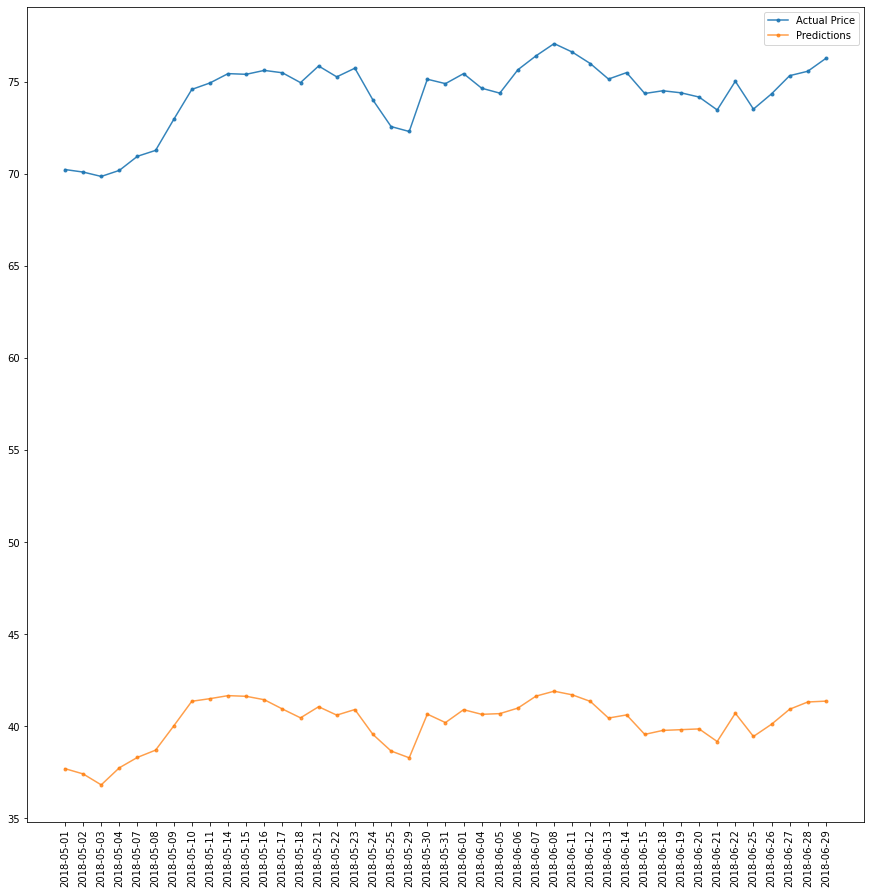

In [44]:
_ = plt.figure(figsize=(15,15))
_ = plt.plot(month['price'],  marker='.', alpha=0.9)
_ = plt.plot(month['predicted_price'], marker='.', alpha=0.75)
_ = plt.legend(['Actual Price', 'Predictions'])
_ = plt.xticks(rotation=90)
plt.show()

In [ ]:
test_df = test_df.tail(40).head(30)
X_test = test_df[['back_5', 'back_4', 'back_3', 'back_2', 'back_1']].values
test_preds = model.predict(X_test)
test_preds = np.exp(test_preds)
test_df['price'] = raw_data['Adj Close']
test_df['predictions'] = test_preds
test_df['pred'] = (test_df['predictions'] * test_df['price'])
test_df

In [ ]:
_ = plt.figure(figsize=(15,15))
_ = plt.plot(test_df['price'], marker='.')
_ = plt.plot(test_df['pred'], marker='.')
_ = plt.xticks(rotation=90)
_ = plt.legend(['Actual Price', 'Predictions'])
plt.show()

In [ ]:
int('stop notebook execution')

In [ ]:
def revert_data(predictions):
    
    # undo scale
    #scaler = joblib.load('../models/MinMaxScaler.save')
    #unscaled_deltas = scaler.inverse_transform(predictions)
    
    # undo log
    #inv_log = np.exp(unscaled_deltas)
    inv_log = np.exp(predictions)
    
    return inv_log
x = revert_data(predictions)
(x.min(), x.max())

In [ ]:

scaler = joblib.load('../models/MinMaxScaler.save')
unscaled_deltas = scaler.inverse_transform(predictions)
unscaled_deltas

scaler.inverse_transform([[0.81, 0.12, 3.3], [0,1, -2]])

In [ ]:
x1 = np.array([[ 0.12417709, -0.08672323,  0.88525218],[-0.12340155,  0.1822511 , -0.73470684]])
scaler.transform(x1)

In [ ]:
inv_log = np.exp(predictions)
inv_log

In [ ]:
inv_log.min(), inv_log.max()

In [ ]:
_ = plt.figure(figsize=(14,7))
_ = plt.plot(predictions, linestyle='None', marker='.')
plt.show()

In [ ]:
def get_Dense_model(input_shape):
    #initialize a sequential keras model
    model = Sequential()

    # build three layers with 100 nodes each
    model.add(Dense(100, activation='relu', input_shape=input_shape))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))

    # build final layer that will contain the output prediction
    model.add(Dense(1))

In [ ]:
def get_LSTR_model(input_shape):
    # Matt and Druv's architecture
    #initialize a sequential keras model
    model = Sequential()

    # build three layers with 100 nodes each
    model.add(LSTR(50, return_sequence=True, input_shape=input_shape))
    model.add(LSTR(50, return_sequence=True)
    model.add(LSTR(50))

    # build final layer that will contain the output prediction
    model.add(Dense(1))
    
    mode.complile(loss='mse', optimizer='adam')
    
              

In [ ]:
lr_to_test = [0.00001, 0.01, 1]
input_shape = (n_cols,)

# loop over learning rates
for lr in lr_to_test:
    model = get_new_model(input_shape)
    
    # use Stochastic Gradient Descent
    optimizer = SGD(lr=lr)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    mse = sum((predictions - y_test)**2)
    
    print(lr, mse)